# Differentiators in PySINDy

This notebook explores the differentiation methods available in PySINDy. Most of the methods are powered by the [derivative](https://pypi.org/project/derivative/) package.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
import seaborn as sns

import pysindy as ps

In the cell below we define all the available differentiators. Note that the different options in `SINDyDerivative` all originate from `derivative`.

* `FiniteDifference` - First order (forward difference) or second order (centered difference) finite difference methods with the ability to drop endpoints. Does *not* assume a uniform time step. Appropriate for smooth data.
* `finite_difference` - Central finite differences of any order. Assumes a uniform time step. Appropriate for smooth data.
* `Smoothed Finite Difference` - `FiniteDifference` with a smoother (default is Savitzky Golay) applied to the data before differentiation. Appropriate for noisy data.
* `savitzky_golay` - Perform a least-squares fit of a polynomial to the data, then compute the derivative of the polynomial. Appropriate for noisy data.
* `spline` - Fit the data with a spline (of arbitrary order) then perform differentiation on the spline. Appropriate for noisy data.
* `trend_filtered` - Use total squared variations to fit the data (computes a global derivative that is a piecewise combination of polynomials of a chosen order). Set `order=0` to obtain the total-variational derivative. Appropriate for noisy data
* `spectral` - Compute the spectral derivative of the data via Fourier Transform. Appropriate for very smooth (i.e. analytic) data.

In [2]:
diffs = [
    ('PySINDy Finite Difference', ps.FiniteDifference()),
    ('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=1)),
    ('Smoothed Finite Difference', ps.SmoothedFiniteDifference()),
    ('Savitzky Golay', ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)),
    ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2)),
    ('Trend Filtered', ps.SINDyDerivative(kind='trend_filtered', order=0, alpha=1e-2)),
    ('Spectral', ps.SINDyDerivative(kind='spectral')),
]

plot_kws = dict(alpha=0.7, linewidth=3)
pal = sns.color_palette("Set1")

## Compare differentiation methods directly
First we'll use the methods to numerically approximate derivatives to measurement data directly, without bringing SINDy into the picture. We'll compare the different methods' accuracies when working with clean data ("approx" in the plots) and data with a small amount of white noise ("noisy").

In [3]:
noise_level = 0.01

In [4]:
def compare_methods(diffs, x, y, y_noisy, y_dot):
    n_methods = len(diffs)
    n_rows = (n_methods // 3) + int(n_methods % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for (name, method), ax in zip(diffs, axs.flatten()):
        ax.plot(x, y_dot, label='Exact', color=pal[0], **plot_kws)
        ax.plot(x, method(y, x), ':', label='Approx.', color='black', **plot_kws)
        ax.plot(x, method(y_noisy, x), label='Noisy', color=pal[1], **plot_kws)
        ax.set(title=name)

    axs[0, 0].legend()
    fig.show()
    
    return axs

### Sine

/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004372207567003343, tolerance: 0.0042094533933600175
  positive)


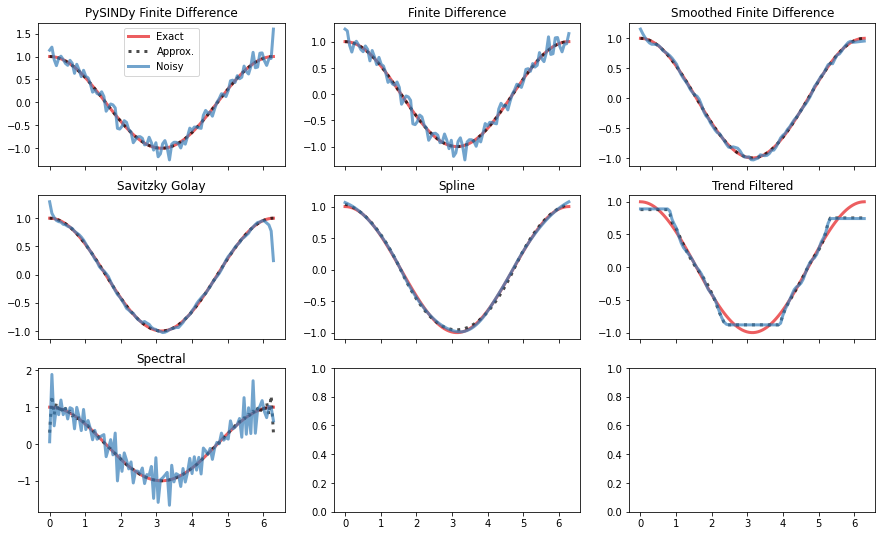

In [5]:
# True data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)
y_dot = np.cos(x)

# Add noise
seed = 111
np.random.seed(seed)
y_noisy = y + noise_level * np.random.randn(len(y))

axs = compare_methods(diffs, x, y, y_noisy, y_dot)

### Absolute value

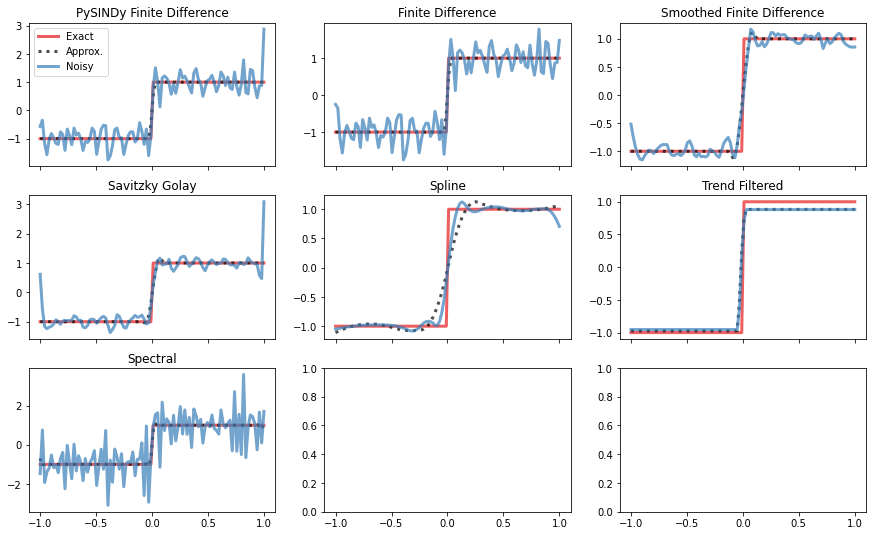

In [6]:
# Shrink window for Savitzky Golay method
diffs[3] = ('Savitzky Golay', ps.SINDyDerivative(kind='savitzky_golay', left=0.1, right=0.1, order=3))

# True data
x = np.linspace(-1, 1, 100)
y = np.abs(x)
y_dot = np.sign(x)

# Add noise
seed = 111
np.random.seed(seed)
y_noisy = y + noise_level * np.random.randn(len(y))

axs = compare_methods(diffs, x, y, y_noisy, y_dot)

## Compare differentiators when used in PySINDy
We got some idea of the performance of the differentiation options applied to raw data. Next we'll look at how they work as a single component of the SINDy algorithm.

In [7]:
noise_level = 0.1

In [8]:
def print_equations(equations_clean, equations_noisy):
    print(f"{'':<30} {'Noiseless':<40} {'Noisy':<40}")
    
    for name in equations_clean.keys():
        print(f"{name:<30} {'':<40} {'':<40}")

        for k, (eq1, eq2) in enumerate(zip(equations_clean[name], equations_noisy[name])):
            print(f"{'':<30} {'x' + str(k) + '=' + str(eq1):<40} {'x' + str(k) + '=' + str(eq2):<40}")
        
        print("-------------------------------------------------------------------------------------------")

### Linear oscillator
$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [9]:
# Generate training data
def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]        
    ]


dt = 0.01
t_train = np.arange(0, 10, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

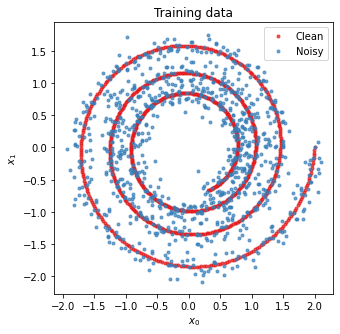

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(x_train[:, 0], x_train[:, 1], '.', label="Clean", color=pal[0], **plot_kws)
ax.plot(x_train_noisy[:, 0], x_train_noisy[:, 1], '.', label="Noisy", color=pal[1], **plot_kws)

ax.set(title='Training data', xlabel='$x_0$', ylabel='$x_1$')
ax.legend()
fig.show()

In [11]:
# Allow Trend Filtered method to work with linear functions
diffs[5] = ('Trend Filtered', ps.SINDyDerivative(kind='trend_filtered', order=1, alpha=1e-2))

equations_clean = {}
equations_noisy = {}
threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt
    )
    
    model.fit(x_train)
    equations_clean[name] = model.equations()
    
    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()

/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.32050014824955, tolerance: 0.1275321846845299
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.25826692995427, tolerance: 0.08566773642368007
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.04844473070442, tolerance: 0.1313715819458219
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

In [12]:
print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy Finite Difference                                                                                       
                               x0=2.006 x1                              x0=2.022 x1                             
                               x1=-1.994 x0                             x1=-2.016 x0                            
-------------------------------------------------------------------------------------------
Finite Difference                                                                                               
                               x0=2.006 x1                              x0=2.034 x1                             
                               x1=-1.994 x0                             x1=-2.042 x0                            
-------------------------------------------------------------------------------------------
Smoothed Finite Differenc

### Lorenz system

$$ \begin{aligned} \dot x &= 10(y-x)\\ \dot y &= x(28 - z) - y \\ \dot z &= xy - \tfrac{8}{3} z, \end{aligned} $$


In [13]:
noise_level = 0.5

In [14]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

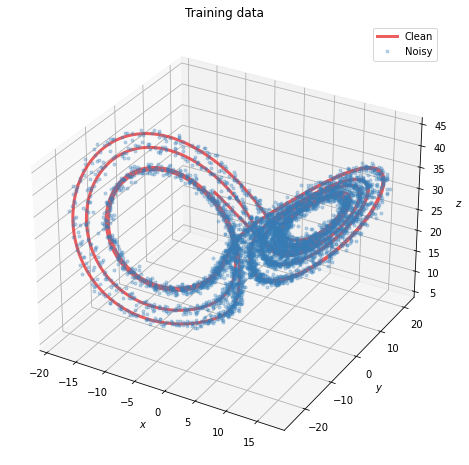

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot(
    x_train[:, 0],
    x_train[:, 1],
    x_train[:, 2],
    color=pal[0],
    label='Clean',
    **plot_kws
)

ax.plot(
    x_train_noisy[:, 0],
    x_train_noisy[:, 1],
    x_train_noisy[:, 2],
    '.',
    color=pal[1],
    label='Noisy',
    alpha=0.3,
)
ax.set(title='Training data', xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()
fig.show()

In [16]:
equations_clean = {}
equations_noisy = {}
threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt
    )
    
    model.fit(x_train)
    equations_clean[name] = model.equations()
    
    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()

/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56656.62263993622, tolerance: 45.824876561391726
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93381.20164219479, tolerance: 32.80629855639771
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160103.90643145746, tolerance: 36.8265379982822
  positive)
/home2/bdesilva/Dropbox (uwamath)/Brian/Research/SINDy/pysindy/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients


In [17]:
print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy Finite Difference                                                                                       
                               x0=-9.999 x0 + 9.999 x1                  x0=-9.939 x0 + 9.975 x1                 
                               x1=27.992 x0 + -0.999 x1 + -1.000 x0 x2  x1=24.922 x0 + -0.933 x0 x2             
                               x2=-2.666 x2 + 1.000 x0 x1               x2=-2.622 x2 + 0.994 x0 x1              
-------------------------------------------------------------------------------------------
Finite Difference                                                                                               
                               x0=-9.999 x0 + 9.999 x1                  x0=-9.873 x0 + 9.907 x1                 
                               x1=27.993 x0 + -0.999 x1 + -1.000 x0 x2  x1=0.633 1 + 24.936 x0 + -0.933 x0 x2   
    